In [1]:
import csv
import torch
import torchaudio
from huggingface_hub import InferenceClient
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from jiwer import wer
import google.generativeai as genai
import os
import dataset
from concurrent.futures import ThreadPoolExecutor, as_completed
import ssl
import dotenv



In [12]:
dataset = datasets.load_dataset("AILAB-VNUHCM/vivos", split="test" ,trust_remote_code=True)

In [13]:
dataset

Dataset({
    features: ['speaker_id', 'path', 'audio', 'sentence'],
    num_rows: 760
})

In [4]:
import re

def in_words_by_level(number, max_level, level = 0):
	"""
		Cách viết bằng chữ của số ở từng hàng
		(đơn vị, chục, trăm, nghìn, triệu, tỉ)
	"""
	digits = ['không', 'một', 'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín']

	levels = [
		'',       #0
		'',       #1x
		' trăm',  #2xx
		' nghìn', #3.xxx
		'',       #4x.xxx
		' trăm',  #5x.xxx
		' triệu', #6.xxx.xxx
		'',       #7x.xxx.xxx
		' trăm',  #8xx.xxx.xxx
		' tỉ',    #9.xxx.xxx.xxx
	]

	if level == 0: # hàng đơn vị
		words_ = digits[number]

	elif level in [1, 4, 7]: # hàng chục
		if number > 1:
			words_ = digits[number] + ' mươi'
		elif number == 1:
			words_ = 'mười'
		else:
			words_ = 'linh'

	else: # hàng trăm | nghìn | triệu | tỉ
		words_ = digits[number] + levels[level]

	return words_

def in_words_by_group(chunk, is_last_chunk):
	"""
		Lần lượt ghi bằng chữ cho từng số trong dãy
	"""

	words_ = []

	max_level = len(chunk)

	# Bỏ qua hàng đơn vị nếu thuộc nhóm từ 10 tỉ trở lên
	level = max_level - 1 if is_last_chunk is True else max_level

	for step in range(max_level):
		number = int(chunk[step])
		words_.append(in_words_by_level(number, len(chunk), level - step))

	return words_

def validate_number(number):
	"""
		Kiểm tra tính hợp lệ và định dạng lại số đã nhập
	"""

	# Chuyển số đầu vào sang định dạng chuỗi
	number = str(number).strip()

	# Bỏ các số 0 ở đầu dãy số (nếu có)
	number = re.sub(r'^0+([1-9])', '\\1', number)

	# Dùng cả dấu phảy và dấu chấm
	if re.search('\.', number) and re.search(',', number):
		print('Có thể là số thập phân')
		return False

	# Dùng dấu . hay dấu , làm dấu phân cách?
	separator = None
	for s in ['.', ',']:
		if re.search(f'\\{s}', number):
			separator = s
			break

	# Kiểm tra cấu trúc phân cách hàng nghìn (nếu có)
	if separator is not None:
		chunks = number.split(separator)
		for i, chunk in enumerate(chunks):
			if (i == 0 and len(chunk) > 3) or (i > 0 and len(chunk) != 3):
				print('Kiểm tra lại dấu phân cách hàng nghìn')
				return False

		# Bỏ dấu phân cách
		number = re.sub(f'\\{separator}', '', number)

	# Có phải tất cả đều là chữ số?
	if re.search(r'^[0-9]+$', number) is None:
		print('Số không hợp lệ')
		return False

	return str(number)

def numbers2words(the_number):
	"""
		Chuyển số sang dạng viết bằng chữ
	"""

	the_number = validate_number(the_number)

	if the_number is False:
		return False

	# print("{:,}".format(int(the_number)).replace(',', '.'))

	# Trả luôn về "Không" nếu là số 0
	if re.match(r'^0+$', the_number):
		return "Không"

	number_length = len(the_number)

	if number_length > 10: # Số >= 10 tỉ
		chunks = []
		temp = the_number
		is_last = True

		# Chia số thành từng nhóm, từ phải sang trái
		while len(temp) > 0:
			if is_last is True:
				# Nhóm đầu tiên gồm 10 chữ số cuối cùng
				chunks.append(temp[-10:])
				temp = temp[:-10]
			else:
				# Các nhóm còn lại có tối đa 9 chữ số
				chunks.append(temp[-9:])
				temp = temp[:-9]

			is_last = False

		# Đảo thứ tự nhóm về theo thứ tự ban đầu (từ trái sang phái)
		chunks.reverse()
		
		words_ = []
		
		# Lần lượt xử lí từng nhóm
		for chunk in chunks:

			is_last_chunk = True if 10 == len(chunk) else False

			words_ += in_words_by_group(chunk, is_last_chunk)

	else:
		words_ = in_words_by_group(the_number, True)

	# Hiệu chỉnh văn bản đầu ra
	words = ' '.join(words_)

	words = words.strip()
	words = re.sub(r'\s+', ' ', words)

	words = re.sub(r'(mười|mươi) không', '\\1', words)
	words = re.sub(r'không trăm linh không (triệu|nghìn)', '', words)
	words = words.replace('không trăm linh không', '')
	words = words.replace('linh không', '')

	words = words.replace('mươi một', 'mươi mốt')
	words = words.replace('mươi bốn', 'mươi tư')
	words = words.replace('mươi năm', 'mươi lăm')

	words = re.sub(r'\s+', ' ', words)

	words = re.sub(r' không (trăm|nghìn|triệu|tỉ)\s?$', '', words)

	return words

def normalize_text(response):
    # Convert the input to a string if it's not already
    if not isinstance(response, str):
        response = str(response)

    # Replace specific tokens and strip unwanted spaces
    response = response.replace("<pad>", "").replace("<s>", "").replace("</s>", "").strip().replace(".", "").replace(",", "")
    response = response.lower()

    # Find numbers in the text
    numbers = re.findall(r'(\d+)', response)

    # Convert each number to words
    for number in numbers:
        words = numbers2words(number)
        if words is not False:
            response = response.replace(number, words)
    
    return response

<>:69: SyntaxWarning: invalid escape sequence '\.'
<>:69: SyntaxWarning: invalid escape sequence '\.'
C:\Users\phucd\AppData\Local\Temp\ipykernel_98140\1317579560.py:69: SyntaxWarning: invalid escape sequence '\.'
  if re.search('\.', number) and re.search(',', number):


In [15]:

# Evaluate both models and export results to CSV

def process_and_append(example, whisper_processor, whisper_model, language, output_csv):
    """
    Process a single example and append the result directly to the CSV file.

    Args:
        example (dict): Dictionary containing audio path and reference sentence.
        whisper_processor: Preloaded Whisper processor.
        whisper_model: Preloaded Whisper model.
        gemini_model: Preloaded Gemini model.
        language (str): Language code for transcription.
        output_csv (str): Path to the output CSV file.

    Returns:
        None
    """
    audio_path = example['path']
    sentence = example["sentence"]

    try:
        # Check audio data
        if 'audio' in example:
            waveform = torch.tensor(example['audio']['array'], dtype=torch.float32).unsqueeze(0)
            sample_rate = example['audio']['sampling_rate']
        else:
            waveform, sample_rate = torchaudio.load(audio_path)

        # Whisper transcription
        inputs = whisper_processor(
            waveform.squeeze().numpy(),
            sampling_rate=sample_rate,
            return_tensors="pt",
            language=language,
            task="transcribe"
        )
        predicted_ids = whisper_model.generate(inputs.input_features)
        whisper_transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        # Initialize Gemini client
        gemini_model = genai.GenerativeModel("gemini-2.0-flash-exp")
        genai.configure(api_key=dotenv.get_key('.env', 'API_KEY'))

        # Gemini transcription
        audio_data = genai.upload_file(audio_path)
        gemini_transcription = gemini_model.generate_content(
            [audio_data, "Generate audio diarization, including transcriptions only."]
        )
        gemini_transcription_text = gemini_transcription.text

        # Decode the text
        gemini_decoded_response = gemini_transcription_text

        if not gemini_decoded_response:
            raise ValueError("Gemini transcription failed or returned empty text.")

        # Append result directly to the CSV
        with open(output_csv, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=["Reference", "Whisper_Transcription", "Gemini_Transcription"])
            if os.stat(output_csv).st_size == 0: 
                writer.writeheader()
            writer.writerow({
                "Reference": sentence,
                "Whisper_Transcription": whisper_transcription,
                "Gemini_Transcription": gemini_decoded_response
            })
        print(f"Processed and appended example: {sentence}")
        print("whisper_transcription: ", whisper_transcription)
        print("gemini_decoded_response: ", gemini_decoded_response)

    except FileNotFoundError:
        print(f"File not found: {audio_path}")
    except Exception as e:
        print(f"Error processing example {audio_path}: {e}")


def evaluate_and_export(dataset, output_csv, language=None, max_threads=4):
    """
    Evaluate transcription models (Whisper and Gemini) on a dataset using threading,
    and append results to the CSV after processing each example.

    Args:
        dataset (list): List of examples, each containing audio and text.
        output_csv (str): Path to the output CSV file.
        language (str, optional): Language code for transcription (e.g., 'en', 'vi').
        max_threads (int): Maximum number of threads to use.

    Returns:
        None
    """
    # Load existing data from the CSV
    existing_data = set()
    if os.path.exists(output_csv):
        with open(output_csv, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                existing_data.add(row["Reference"])

    # Load Whisper model and processor
    whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3-turbo")
    whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v3-turbo")

    # Thread pool for parallel processing
    with ThreadPoolExecutor(max_threads) as executor:
        # Submit tasks for processing examples
        futures = [
            executor.submit(process_and_append, example, whisper_processor, whisper_model, language, output_csv)
            for example in dataset if example["sentence"] not in existing_data
        ]

        # Wait for all tasks to complete
        for future in as_completed(futures):
            future.result()


# Example usage
evaluate_and_export(dataset, "utf8_raw_transcription.csv", language="vi", max_threads=4)


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processed and appended example: THẾ NHƯNG KHI GIÁ PHÔI THÉP THẾ GIỚI CAO DẦN
whisper_transcription:   Thế nhưng khi giả phôi thép thế giới cao dần
gemini_decoded_response:  thế nhưng khi giá phôi thép thế giới cao dần,
Processed and appended example: ÔNG NHẶT NÓ LÊN
whisper_transcription:   Ông nhặt nó lên
gemini_decoded_response:  Ông nhặt nó lên.

Processed and appended example: DOANH NGHIỆP TUYỂN DỤNG LAO ĐỘNG NƯỚC NGOÀI
whisper_transcription:   Doanh nghiệp tuyển dụng lao động nước ngoài
gemini_decoded_response:  Doanh nghiệp tuyển dụng lao động nước ngoài.
Processed and appended example: TỨC KHẮC ẬP VỀ KÉO MỌI NGƯỜI THỨ TRỞ LẠI THỜI HOANG SƠ
whisper_transcription:   Tức khắc ập về kéo mọi người thứ trở lại thời hoang sơ
gemini_decoded_response:  tức khắc ập về kéo mọi người thứ trở lại thời hoang sơ.
Processed and appended example: CHƯA RỤC RỊCH GÌ
whisper_transcription:   Chưa rụt rịch gì
gemini_decoded_response:  Chưa rục rịch gì.

Processed and appended example: RA HIỆU CHO TÔI

In [7]:
import pandas as pd

In [10]:
raw_data = pd.read_csv('./utf8_raw_transcription.csv')

raw_data.head(10)

,Reference,Whisper_Transcription,Gemini_Transcription
0,NỬA VÒNG TRÁI ĐẤT HƠN BẢY NĂM,Nửa vòng trái đất hơn 7 năm,Nửa vòng trái đất hơn 7 năm.
1,CỦA NHỮNG THẾ LỰC HÙNG MẠNH,của những thế lực hùng mạnh,của những thế lực hung hãn.
2,TÊN GỌI TẠI ĐỊA PHƯƠNG LÀ TRẮC THỐI,Tên gọi tại địa phương là Trắc Thối.,tên gọi tại địa phương là trắc thối.
3,HÃY TƯỞNG TƯỢNG RẰNG BẠN LÀ LÀ GIÁM ĐỐC DỰ ÁN ...,Hãy tưởng tượng rằng bạn là giám đốc dự án tr...,Hãy tưởng tượng rằng bạn là giám đốc dự án tro...
4,NHƯNG MÙI HÔI VẪN XỘC VÀO TẬN ÓC,nhưng mùi hôi vẫn sọc vào tận ốc.,Nhưng mùi hôi vẫn sọc vào tận óc.
5,BỐN CHIẾC TRỐNG ĐẠI PHÈNG LA,4 chiếc trống đại phèn la.,Bốn chiếc trống đại phèn la.
6,LẦN LỮA MÃI MỚI GẶP ĐƯỢC TUYÊN,Lần nữa Mãi mới gặp được Tuyên,Lần nữa mãi mới gặp được Tuyên.\r\n
7,NGỒI CHỒM CHỒM CÁCH CHỈ MẤY MÉT,Ngồi trồm trồm cách chỉ mấy mét.,ngồi chồm chồm cách chỉ mấy mét.
8,CẢ KHÔNG GIAN NHUỐM MÀU TRO BẾP,Cả không gian nhuống màu trò bếp,cả không gian nhuốm màu tro bếp.
9,NHƯNG MỨC ÁN TỬ HÌNH ĐỐI VỚI CÁC BỊ CÁO LÀ TƯƠ...,nhưng mức án tử hình đối với các bị cáo là tư...,Nhưng mức án tử hình đối với các bị cáo là tướ...


In [11]:
normalized_data = raw_data.copy()
normalized_data.to_string()
normalized_data['Reference_normalize'] = normalized_data['Reference'].apply(normalize_text)
normalized_data['Whisper_Transcription_normalize'] = normalized_data['Whisper_Transcription'].apply(normalize_text)
normalized_data['Gemini_Transcription_normalize'] = normalized_data['Gemini_Transcription'].apply(normalize_text)

normalized_data.to_csv('normalized_data.csv', index=False, encoding='utf-8')
normalized_data.head(10)


,Reference,Whisper_Transcription,Gemini_Transcription,Reference_normalize,Whisper_Transcription_normalize,Gemini_Transcription_normalize
0,NỬA VÒNG TRÁI ĐẤT HƠN BẢY NĂM,Nửa vòng trái đất hơn 7 năm,Nửa vòng trái đất hơn 7 năm.,nửa vòng trái đất hơn bảy năm,nửa vòng trái đất hơn bảy năm,nửa vòng trái đất hơn bảy năm
1,CỦA NHỮNG THẾ LỰC HÙNG MẠNH,của những thế lực hùng mạnh,của những thế lực hung hãn.,của những thế lực hùng mạnh,của những thế lực hùng mạnh,của những thế lực hung hãn
2,TÊN GỌI TẠI ĐỊA PHƯƠNG LÀ TRẮC THỐI,Tên gọi tại địa phương là Trắc Thối.,tên gọi tại địa phương là trắc thối.,tên gọi tại địa phương là trắc thối,tên gọi tại địa phương là trắc thối,tên gọi tại địa phương là trắc thối
3,HÃY TƯỞNG TƯỢNG RẰNG BẠN LÀ LÀ GIÁM ĐỐC DỰ ÁN ...,Hãy tưởng tượng rằng bạn là giám đốc dự án tr...,Hãy tưởng tượng rằng bạn là giám đốc dự án tro...,hãy tưởng tượng rằng bạn là là giám đốc dự án ...,hãy tưởng tượng rằng bạn là giám đốc dự án tro...,hãy tưởng tượng rằng bạn là giám đốc dự án tro...
4,NHƯNG MÙI HÔI VẪN XỘC VÀO TẬN ÓC,nhưng mùi hôi vẫn sọc vào tận ốc.,Nhưng mùi hôi vẫn sọc vào tận óc.,nhưng mùi hôi vẫn xộc vào tận óc,nhưng mùi hôi vẫn sọc vào tận ốc,nhưng mùi hôi vẫn sọc vào tận óc
5,BỐN CHIẾC TRỐNG ĐẠI PHÈNG LA,4 chiếc trống đại phèn la.,Bốn chiếc trống đại phèn la.,bốn chiếc trống đại phèng la,bốn chiếc trống đại phèn la,bốn chiếc trống đại phèn la
6,LẦN LỮA MÃI MỚI GẶP ĐƯỢC TUYÊN,Lần nữa Mãi mới gặp được Tuyên,Lần nữa mãi mới gặp được Tuyên.\r\n,lần lữa mãi mới gặp được tuyên,lần nữa mãi mới gặp được tuyên,lần nữa mãi mới gặp được tuyên
7,NGỒI CHỒM CHỒM CÁCH CHỈ MẤY MÉT,Ngồi trồm trồm cách chỉ mấy mét.,ngồi chồm chồm cách chỉ mấy mét.,ngồi chồm chồm cách chỉ mấy mét,ngồi trồm trồm cách chỉ mấy mét,ngồi chồm chồm cách chỉ mấy mét
8,CẢ KHÔNG GIAN NHUỐM MÀU TRO BẾP,Cả không gian nhuống màu trò bếp,cả không gian nhuốm màu tro bếp.,cả không gian nhuốm màu tro bếp,cả không gian nhuống màu trò bếp,cả không gian nhuốm màu tro bếp
9,NHƯNG MỨC ÁN TỬ HÌNH ĐỐI VỚI CÁC BỊ CÁO LÀ TƯƠ...,nhưng mức án tử hình đối với các bị cáo là tư...,Nhưng mức án tử hình đối với các bị cáo là tướ...,nhưng mức án tử hình đối với các bị cáo là tươ...,nhưng mức án tử hình đối với các bị cáo là tươ...,nhưng mức án tử hình đối với các bị cáo là tướ...


In [12]:
normalized_data['Whisper_Transcription_WER'] = normalized_data.apply(lambda x: wer(x['Reference_normalize'], x['Whisper_Transcription_normalize']), axis=1).round(4)
normalized_data['Gemini_Transcription_WER'] = normalized_data.apply(lambda x: wer(x['Reference_normalize'], x['Gemini_Transcription_normalize']), axis=1).round(4)
normalized_data.head(10)

,Reference,Whisper_Transcription,Gemini_Transcription,Reference_normalize,Whisper_Transcription_normalize,Gemini_Transcription_normalize,Whisper_Transcription_WER,Gemini_Transcription_WER
0,NỬA VÒNG TRÁI ĐẤT HƠN BẢY NĂM,Nửa vòng trái đất hơn 7 năm,Nửa vòng trái đất hơn 7 năm.,nửa vòng trái đất hơn bảy năm,nửa vòng trái đất hơn bảy năm,nửa vòng trái đất hơn bảy năm,0.0000,0.0000
1,CỦA NHỮNG THẾ LỰC HÙNG MẠNH,của những thế lực hùng mạnh,của những thế lực hung hãn.,của những thế lực hùng mạnh,của những thế lực hùng mạnh,của những thế lực hung hãn,0.0000,0.3333
2,TÊN GỌI TẠI ĐỊA PHƯƠNG LÀ TRẮC THỐI,Tên gọi tại địa phương là Trắc Thối.,tên gọi tại địa phương là trắc thối.,tên gọi tại địa phương là trắc thối,tên gọi tại địa phương là trắc thối,tên gọi tại địa phương là trắc thối,0.0000,0.0000
3,HÃY TƯỞNG TƯỢNG RẰNG BẠN LÀ LÀ GIÁM ĐỐC DỰ ÁN ...,Hãy tưởng tượng rằng bạn là giám đốc dự án tr...,Hãy tưởng tượng rằng bạn là giám đốc dự án tro...,hãy tưởng tượng rằng bạn là là giám đốc dự án ...,hãy tưởng tượng rằng bạn là giám đốc dự án tro...,hãy tưởng tượng rằng bạn là giám đốc dự án tro...,0.0625,0.0625
4,NHƯNG MÙI HÔI VẪN XỘC VÀO TẬN ÓC,nhưng mùi hôi vẫn sọc vào tận ốc.,Nhưng mùi hôi vẫn sọc vào tận óc.,nhưng mùi hôi vẫn xộc vào tận óc,nhưng mùi hôi vẫn sọc vào tận ốc,nhưng mùi hôi vẫn sọc vào tận óc,0.2500,0.1250
5,BỐN CHIẾC TRỐNG ĐẠI PHÈNG LA,4 chiếc trống đại phèn la.,Bốn chiếc trống đại phèn la.,bốn chiếc trống đại phèng la,bốn chiếc trống đại phèn la,bốn chiếc trống đại phèn la,0.1667,0.1667
6,LẦN LỮA MÃI MỚI GẶP ĐƯỢC TUYÊN,Lần nữa Mãi mới gặp được Tuyên,Lần nữa mãi mới gặp được Tuyên.\r\n,lần lữa mãi mới gặp được tuyên,lần nữa mãi mới gặp được tuyên,lần nữa mãi mới gặp được tuyên,0.1429,0.1429
7,NGỒI CHỒM CHỒM CÁCH CHỈ MẤY MÉT,Ngồi trồm trồm cách chỉ mấy mét.,ngồi chồm chồm cách chỉ mấy mét.,ngồi chồm chồm cách chỉ mấy mét,ngồi trồm trồm cách chỉ mấy mét,ngồi chồm chồm cách chỉ mấy mét,0.2857,0.0000
8,CẢ KHÔNG GIAN NHUỐM MÀU TRO BẾP,Cả không gian nhuống màu trò bếp,cả không gian nhuốm màu tro bếp.,cả không gian nhuốm màu tro bếp,cả không gian nhuống màu trò bếp,cả không gian nhuốm màu tro bếp,0.2857,0.0000
9,NHƯNG MỨC ÁN TỬ HÌNH ĐỐI VỚI CÁC BỊ CÁO LÀ TƯƠ...,nhưng mức án tử hình đối với các bị cáo là tư...,Nhưng mức án tử hình đối với các bị cáo là tướ...,nhưng mức án tử hình đối với các bị cáo là tươ...,nhưng mức án tử hình đối với các bị cáo là tươ...,nhưng mức án tử hình đối với các bị cáo là tướ...,0.0769,0.1538


In [13]:
mean_whisper_wer = normalized_data['Whisper_Transcription_WER'].mean()
mean_gemini_wer = normalized_data['Gemini_Transcription_WER'].mean()
mean_whisper_wer, mean_gemini_wer
normalized_data.to_csv('WER_data.csv', index=False)

In [14]:
print("Whisper WER: ", mean_whisper_wer)

print("Gemini WER: ", mean_gemini_wer)

Whisper WER:  0.11775046604527296
Gemini WER:  0.09608295605858855


C:\Users\phucd\AppData\Local\Temp\ipykernel_98140\1103170086.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Whisper", "Gemini"], y=[mean_whisper_wer, mean_gemini_wer], palette="viridis")


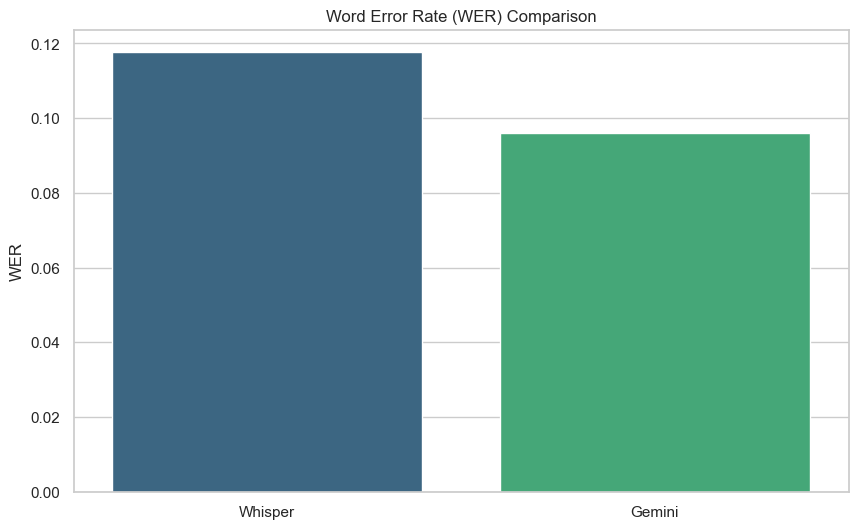

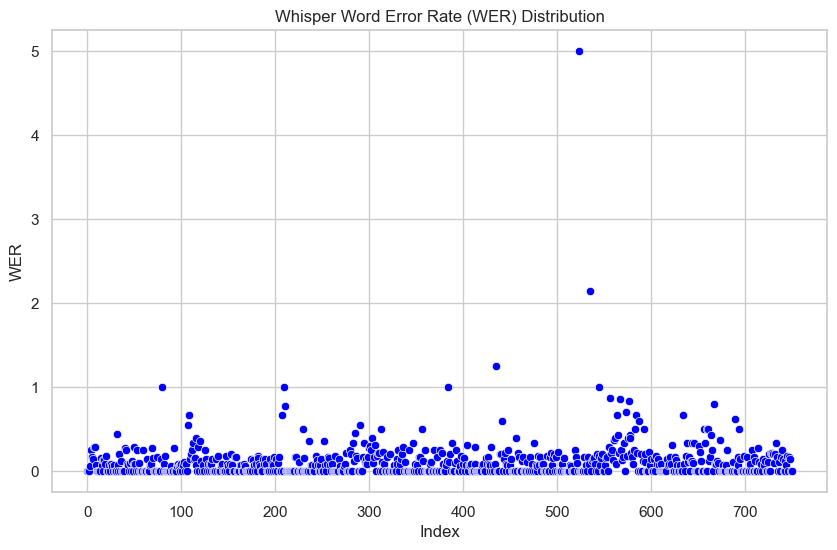

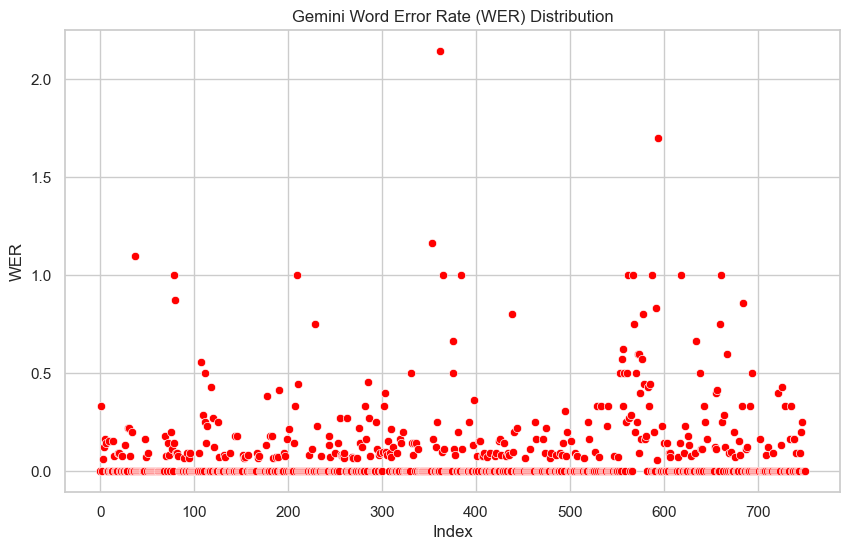

In [15]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Create a bar plot for WER
plt.figure(figsize=(10, 6))
sns.barplot(x=["Whisper", "Gemini"], y=[mean_whisper_wer, mean_gemini_wer], palette="viridis")
plt.title("Word Error Rate (WER) Comparison")
plt.ylabel("WER")
plt.show()


# Create a scatter plot for Whisper WER
plt.figure(figsize=(10, 6))
sns.scatterplot(x=normalized_data.index, y=normalized_data["Whisper_Transcription_WER"], color="blue")
plt.title("Whisper Word Error Rate (WER) Distribution")
plt.ylabel("WER")
plt.xlabel("Index")
plt.show()

# Create a scatter plot for Gemini WER
plt.figure(figsize=(10, 6))
sns.scatterplot(x=normalized_data.index, y=normalized_data["Gemini_Transcription_WER"], color="red")
plt.title("Gemini Word Error Rate (WER) Distribution")
plt.ylabel("WER")
plt.xlabel("Index")
plt.show()
